# Predicting NBA Player Points per Game based on Player Characteristics
### Group 3

**Group Members:** Amy Kong, Jordon Chen, Rashi Selarka, Xuerong Wang

# Introduction

Basketball is a sport that requires one team to score more points than the other team in order to win (Logan). Consequently, players that score more points per game tend to have a higher impact and value than those that do not. Many variables can affect a player’s ability to score (Greenberg), and in this project, we will explore a basketball dataset of NBA players in order to answer the following prediction-focused question:

**How well do an NBA player's years of experience, height, and division predict his points per game?**

The data used was obtained from a table called *Player_Attributes* in an SQLite database on Kaggle called *Basketball Dataset*. This database is updated daily and contains data on all games, all teams, and all players within the NBA; the table we have chosen describes the characteristics of an NBA player, including their physical characteristics (height and weight), basketball statistics, and previous experience. We will be using the following input and response variables.
- `PTS` (Response): Points per game
- `HEIGHT` (Input): height in inches
- `SEASON_EXP` (Input): season/years played
- `DIVISION` (Input, not part of initial dataset): team division

The average height of an NBA player has increased over the years, and this is associated with increased field-goal percentage, indicating that there may also be an association with points per game as players have begun to score more efficiently. Additionally, older players tend to be more savvy, knowledgeable and understand how to manipulate the rules of basketball, meaning that there could be a positive association between years played and points per game. Lastly, we would also like to explore the association between division and points per game, as different regions have different climates and elevations that may impact a player's fitness and overall ability to score points.

# Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(carData)
library(broom)
library(leaps)
library(mltools)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
# loading the data
basketball_data <- read_csv("/home/jupyter/stat-301/Player_Attributes.csv")

"Table 1: Initial Dataset"
head(basketball_data)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  ID = col_double(),
  BIRTHDATE = col_datetime(format = ""),
  HEIGHT = col_double(),
  WEIGHT = col_double(),
  SEASON_EXP = col_double(),
  TEAM_ID = col_double(),
  FROM_YEAR = col_double(),
  TO_YEAR = col_double(),
  PTS = col_double(),
  AST = col_double(),
  REB = col_double(),
  ALL_STAR_APPEARANCES = col_double(),
  PIE = col_double()
)
ℹ Use `spec()` for the full column specifications.




[1] "Table 1: Initial Dataset"

ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,⋯,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76001,Alaa,Abdelnaby,Alaa Abdelnaby,"Abdelnaby, Alaa",A. Abdelnaby,alaa-abdelnaby,1968-06-24,Duke,USA,⋯,Y,Y,1990,1,25,5.7,0.3,3.3,0,NA
76002,Zaid,Abdul-Aziz,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",Z. Abdul-Aziz,zaid-abdul-aziz,1946-04-07,Iowa State,USA,⋯,Y,Y,1968,1,5,9.0,1.2,8.0,0,NA
76003,Kareem,Abdul-Jabbar,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",K. Abdul-Jabbar,kareem-abdul-jabbar,1947-04-16,UCLA,USA,⋯,Y,Y,1969,1,1,24.6,3.6,11.2,18,NA
51,Mahmoud,Abdul-Rauf,Mahmoud Abdul-Rauf,"Abdul-Rauf, Mahmoud",M. Abdul-Rauf,mahmoud-abdul-rauf,1969-03-09,Louisiana State,USA,⋯,Y,Y,1990,1,3,14.6,3.5,1.9,0,NA
1505,Tariq,Abdul-Wahad,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",T. Abdul-Wahad,tariq-abdul-wahad,1974-11-03,San Jose State,France,⋯,Y,Y,1997,1,11,7.8,1.1,3.3,0,NA
949,Shareef,Abdur-Rahim,Shareef Abdur-Rahim,"Abdur-Rahim, Shareef",S. Abdur-Rahim,shareef-abdur-rahim,1976-12-11,California,USA,⋯,Y,Y,1996,1,3,18.1,2.5,7.5,1,NA


To get the dataset we want to work with, we first tidy the data to filter out unnecessary columns. Then, we classify teams in their respective divisions from ESPN's current NBA standings.

In [3]:
# selecting the relevant explanatory and response variables
basketball_data <- basketball_data %>%
    select(SEASON_EXP, HEIGHT, TEAM_NAME, PTS) %>%
        filter(!is.na(TEAM_NAME)) %>%
        filter(!is.na(SEASON_EXP)) %>%
        filter(!is.na(HEIGHT)) %>%
        filter(!is.na(PTS))

# classifying teams into their respective divisions from ESPN's current NBA standings
basketball_data <- basketball_data %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Rockets", "Southwest", "ND")) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Grizzlies", "Southwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Spurs", "Southwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Mavericks", "Southwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Pelicans", "Southwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Lakers", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Clippers", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Kings", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Suns", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Royals", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Braves", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Warriors", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Jazz", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Nuggets", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Timberwolves", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "SuperSonics", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Trail Blazers", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Thunder", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Wizards", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Hornets", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Hawks", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Falcons", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Blackhawks", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Bobcats", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Bullets", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Heat", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Magic", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Bulls", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Bucks", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Pistons", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Pacers", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Cavaliers", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Knicks", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Nets", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Raptors", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "76ers", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Nationals", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Celtics", "Atlantic", DIVISION))

In [4]:
# Checking to find team names that haven't been classified yet
basketball_nd <- filter(basketball_data, DIVISION == "ND") %>%
group_by(TEAM_NAME) %>%
summarize(mean = mean(SEASON_EXP))
print(basketball_nd$TEAM_NAME)

 [1] "Bombers"      "Capitols"     "Huskies"      "Ironmen"      "Jets"        
 [6] "Olympians"    "Packers"      "Rebels"       "Redskins"     "Stags"       
[11] "Steamrollers" "Zephyrs"     


In [5]:
# Omitting unclassified rows
basketball_data <- basketball_data %>%
    filter(!TEAM_NAME %in% c("Bombers", "Capitols", "Huskies", "Ironmen", "Jets", "Olympians", "Packers", "Rebels", "Redskins", "Stags", "Steamrollers", "Zephyrs"))

## Tidied Dataset

In [6]:
basketball_data <- basketball_data %>%
    select(SEASON_EXP, HEIGHT, PTS, DIVISION)

"Table 2: Tidied Dataset"
head(basketball_data)

[1] "Table 2: Tidied Dataset"

SEASON_EXP,HEIGHT,PTS,DIVISION
<dbl>,<dbl>,<dbl>,<chr>
4,82,5.7,Northwest
9,81,9.0,Southwest
19,86,24.6,Pacific
8,73,14.6,Northwest
6,78,7.8,Pacific
12,81,18.1,Southwest


Using the tidied data, we use `ggpairs` to look for any association between pairs of variables. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



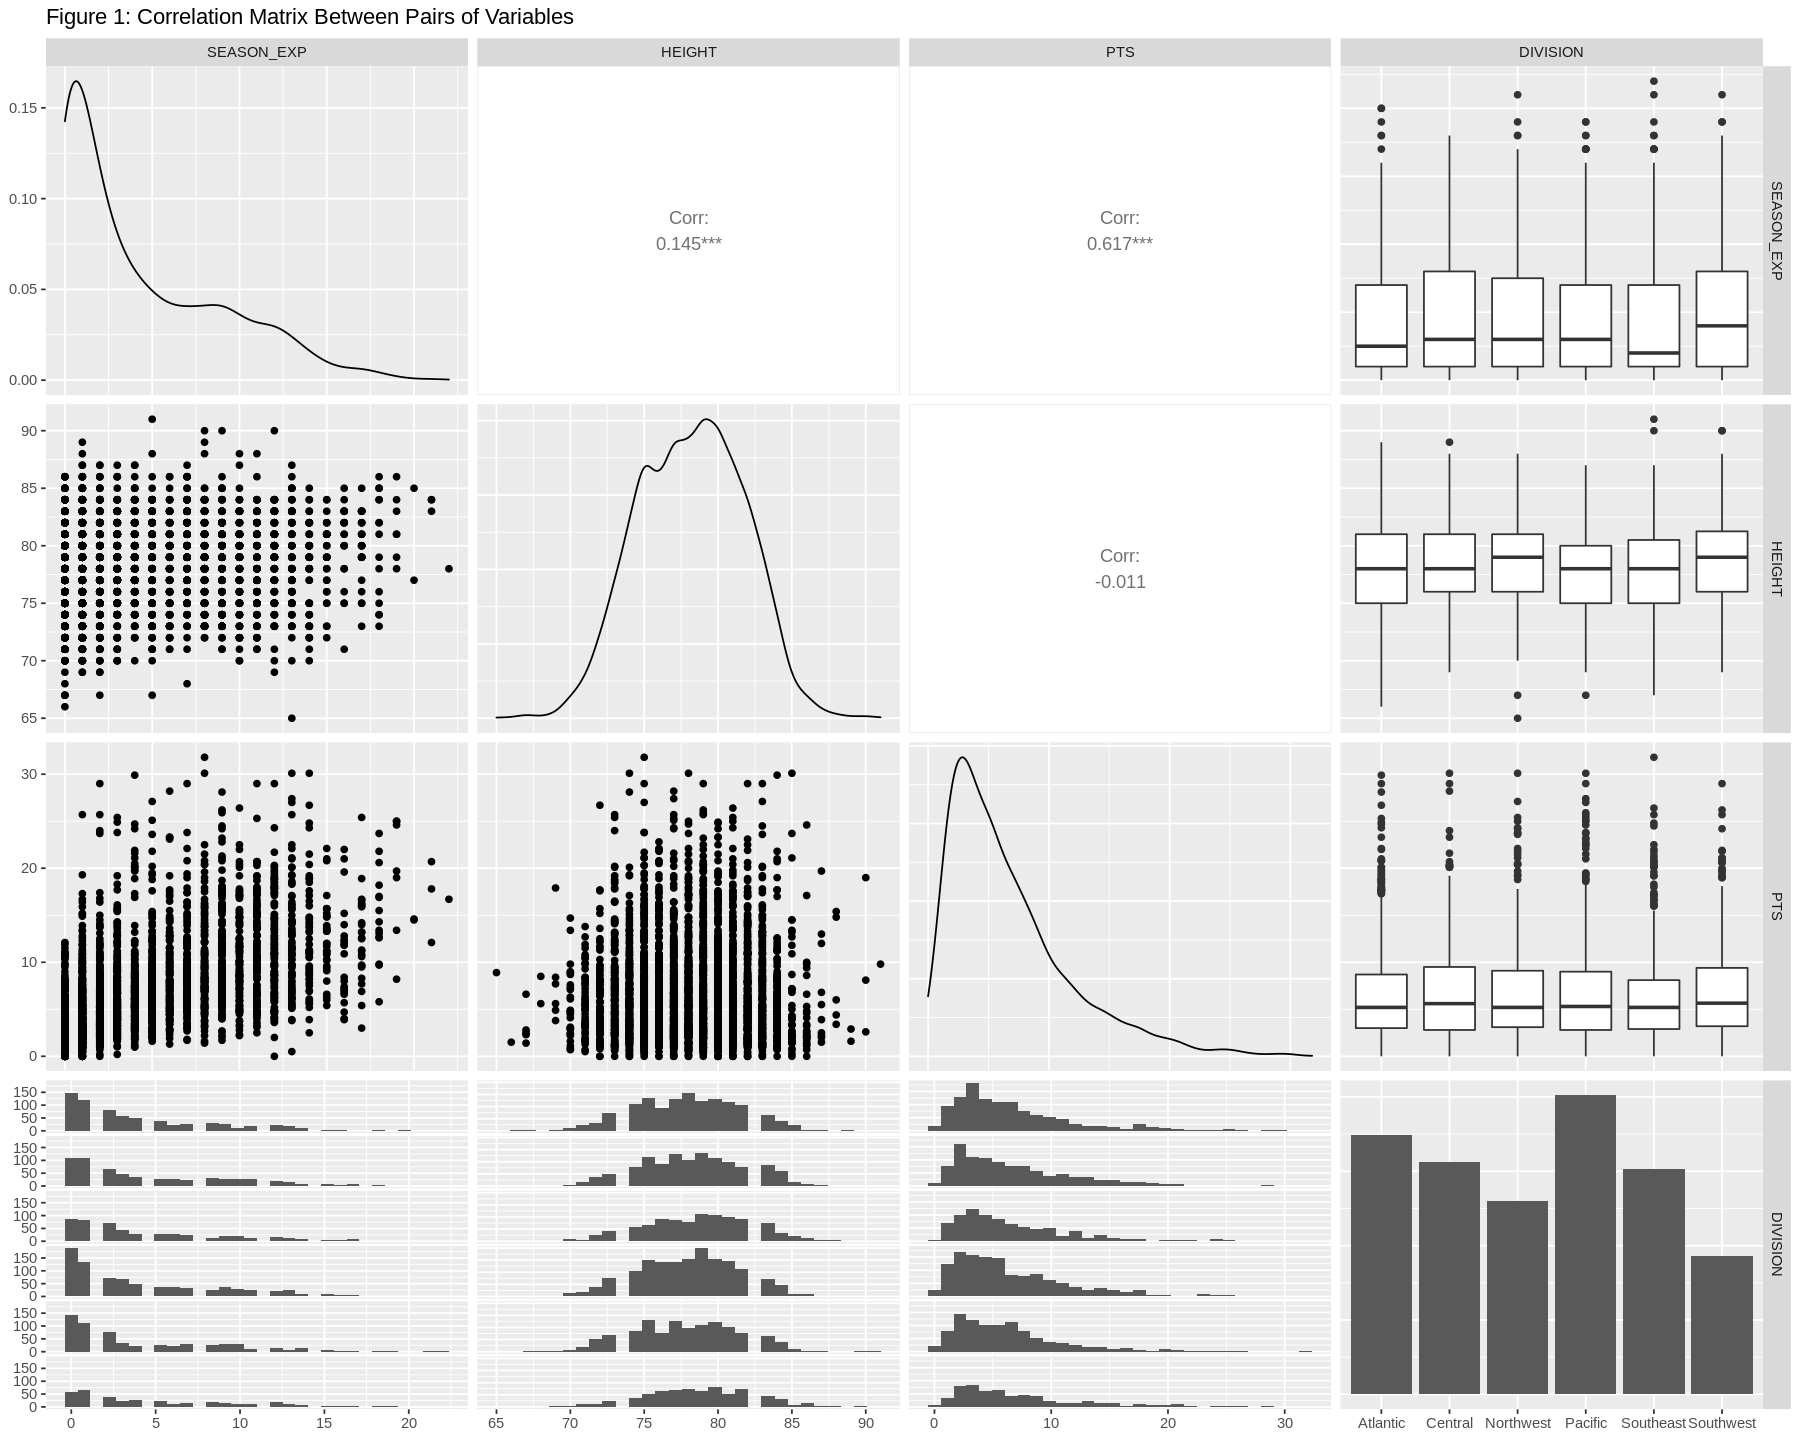

In [7]:
options(repr.plot.width = 15, repr.plot.height = 12)
ggpairs(basketball_data) +
ggtitle("Figure 1: Correlation Matrix Between Pairs of Variables")

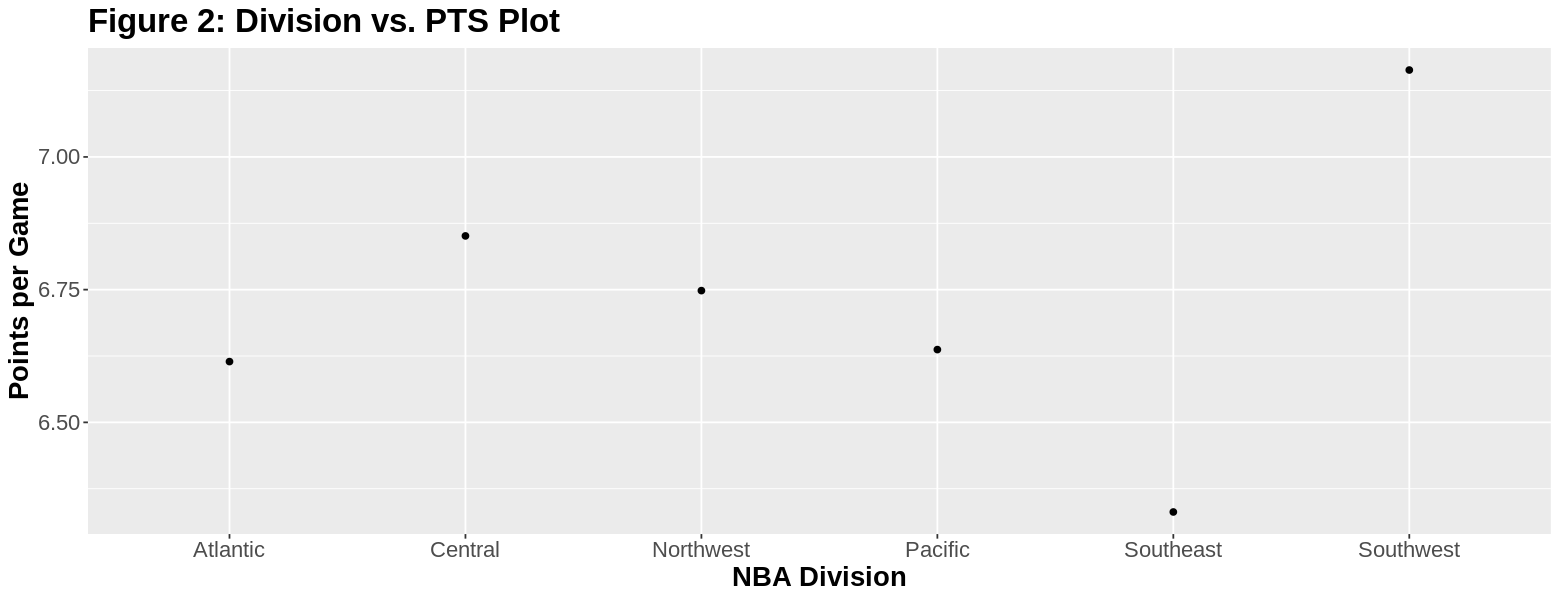

In [8]:
# Plotting the divisions against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_division_data <- basketball_data %>%
    group_by(DIVISION) %>%
    summarize(mean_PTS = mean(PTS))

bb_division_plot <- ggplot(bb_division_data, aes(
  x = DIVISION, y = mean_PTS)) +
  geom_point() +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "NBA Division", y = "Points per Game", title = "Figure 2: Division vs. PTS Plot")
bb_division_plot

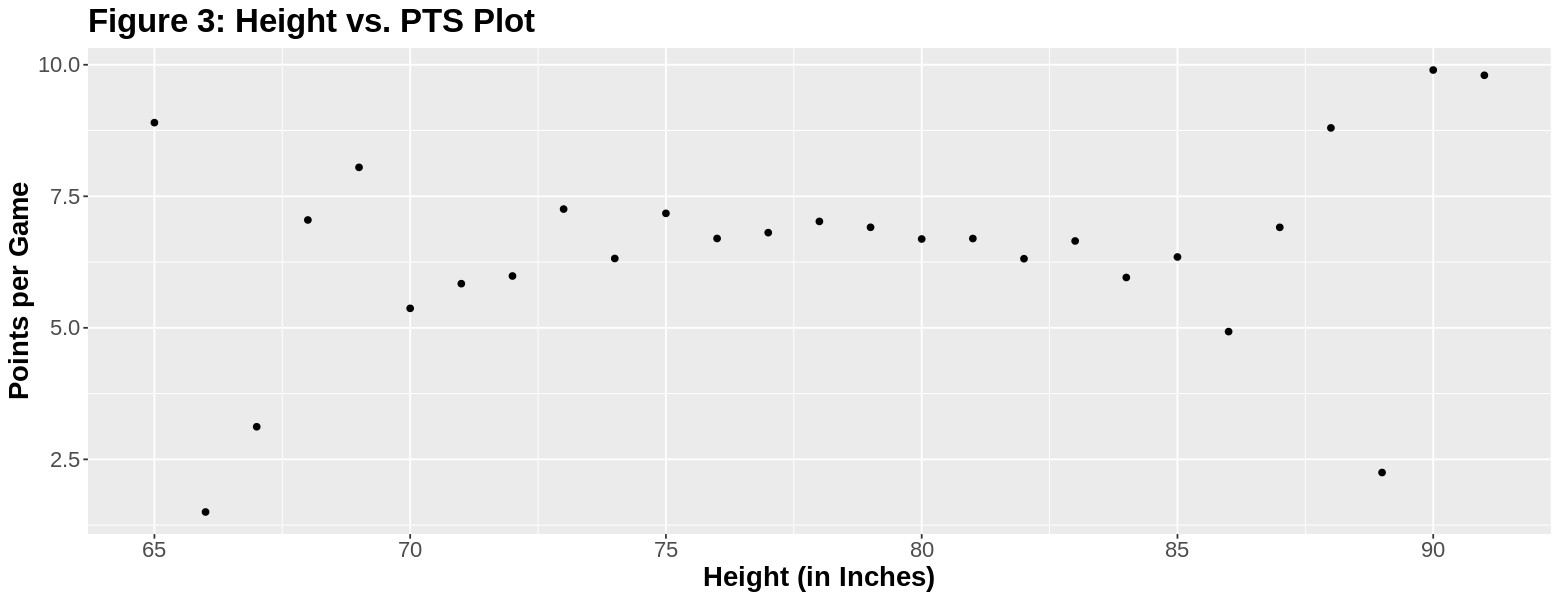

In [9]:
# Plotting the heights against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_height_data <- basketball_data %>%
    group_by(HEIGHT) %>%
    summarize(mean_PTS = mean(PTS))

bb_height_plot <- ggplot(bb_height_data, aes(
  x = HEIGHT, y = mean_PTS)) +
  geom_point() +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "Height (in Inches)", y = "Points per Game", title = "Figure 3: Height vs. PTS Plot")
bb_height_plot

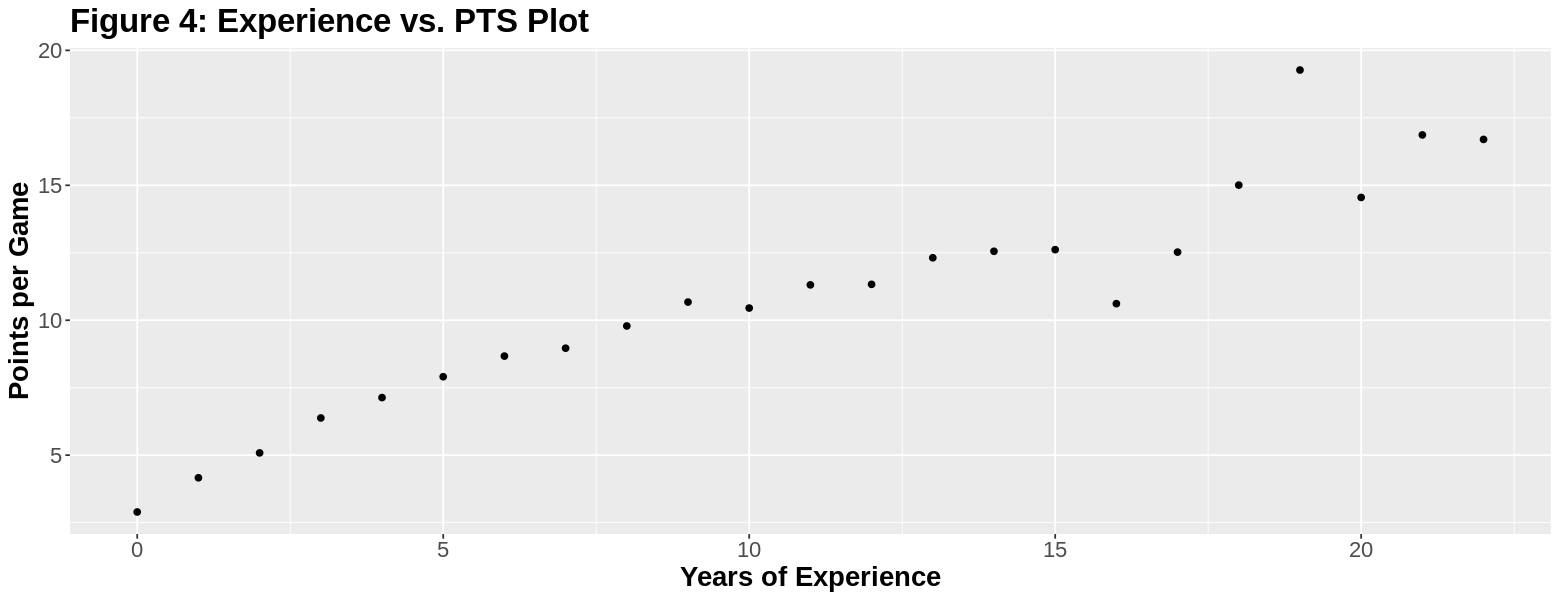

In [10]:
# Plotting the years of experience against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_exp_data <- basketball_data %>%
    group_by(SEASON_EXP) %>%
    summarize(mean_PTS = mean(PTS))

bb_exp_plot <- ggplot(bb_exp_data, aes(
  x = SEASON_EXP, y = mean_PTS)) +
  geom_point() +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "Years of Experience", y = "Points per Game", title = "Figure 4: Experience vs. PTS Plot")
bb_exp_plot

We plot the above 3 plots side-by-side for easier comparision.

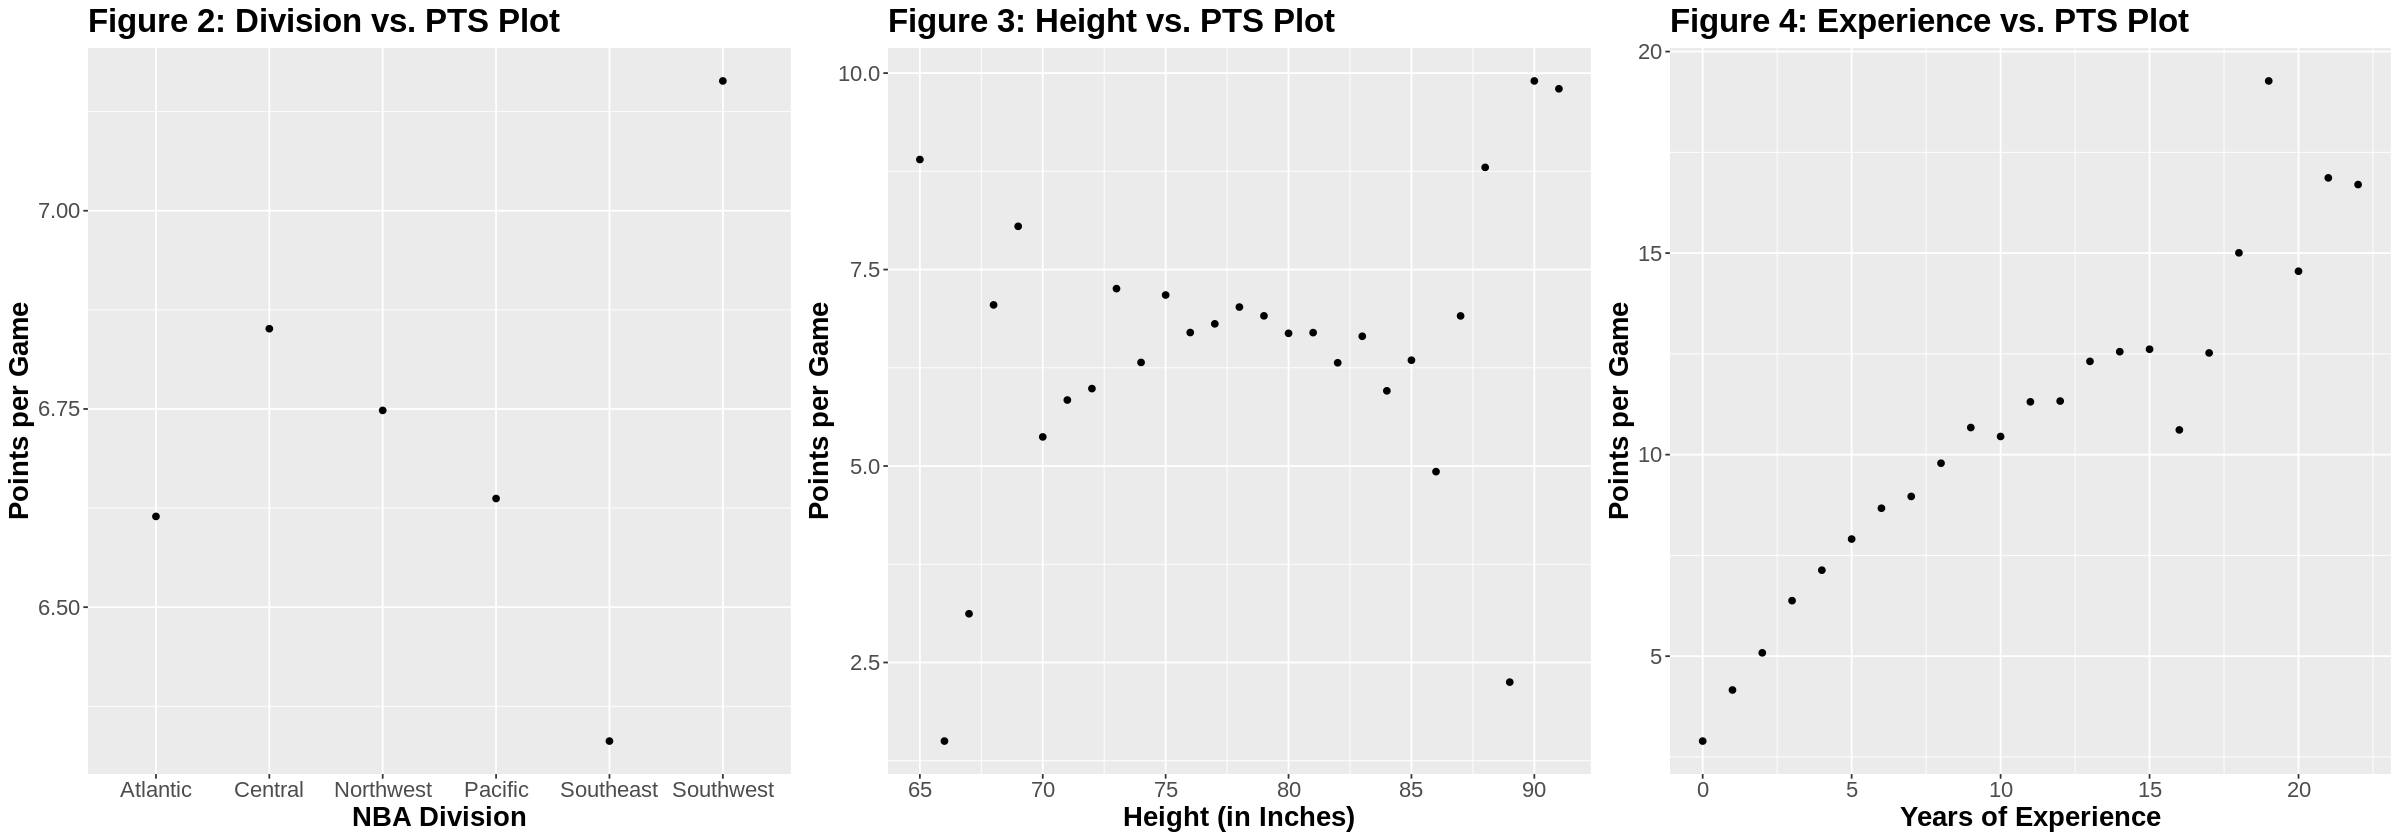

In [11]:
options(repr.plot.width = 20, repr.plot.height = 7)
grid.arrange(bb_division_plot, bb_height_plot, bb_exp_plot, ncol = 3)

From Figure 2, we can see that the division with the highest amount of points per game is the Southwest division followed by Central, Northwest, and so on. 

In Figure 3, we see that a majority of the heights are between 70 and 85 inches, with points per game ranging from 5 to 7.5. With that being said, those with a height of less than 70 inches or those with heights of greater than 85 have a range of 1.25 to 10 points.

And in Figure 4, there is, generally, an increasing trend where an increase in the years of experience is associated with an increase of points per game.

# Methods: Plan

This report takes advantage of the large and detailed dataset, with information spanning from 1946. The large dataset allows more data to be dedicated to training our model, so that it can produce more accurate results.

We will split the whole dataset into training and test datasets. Then we will use the variable selection strategy to choose the best model for prediction. After the model is selected, we will visualize the test data points and the model combining with other statistics to see how the model performs.

Using the best model, we expect to predict how many points a player can get.

Team building is something that could be impacted by our results, as organizations could have preconcieved notions towards younger or older players, or players of a certain height, and this model would help them strategize as accurately as possible. Sports betting could also be influenced, in that bettors would place higher priority in betting on players from certain NBA divisions. Player salaries could also be affected, as players with desired attributes could receive larger contracts. A question to consider for the future would be: what are some other athlete behaviours / KPIs that could be of interest, and what are some of the other variables that could help predict them?

# References

“2021-22 NBA Standings.” ESPN, ESPN Internet Ventures, https://www.espn.com/nba/standings/_/group/division. 

Greenberg, Neil. “Analysis | Here's What's behind the NBA's Scoring Explosion.” The Washington Post, WP Company, 24 Oct. 2018, https://www.washingtonpost.com/sports/2018/10/24/heres-whats-behind-nbas-scoring-explosion/. 

Logan, Robert. “Basketball.” Encyclopædia Britannica, Encyclopædia Britannica, Inc., https://www.britannica.com/sports/basketball. 

Walsh, Wyatt. “Basketball Dataset.” Kaggle, 15 Sept. 2021, https://www.kaggle.com/wyattowalsh/basketball. 